# Exploring Custom Revival with JSON.parse

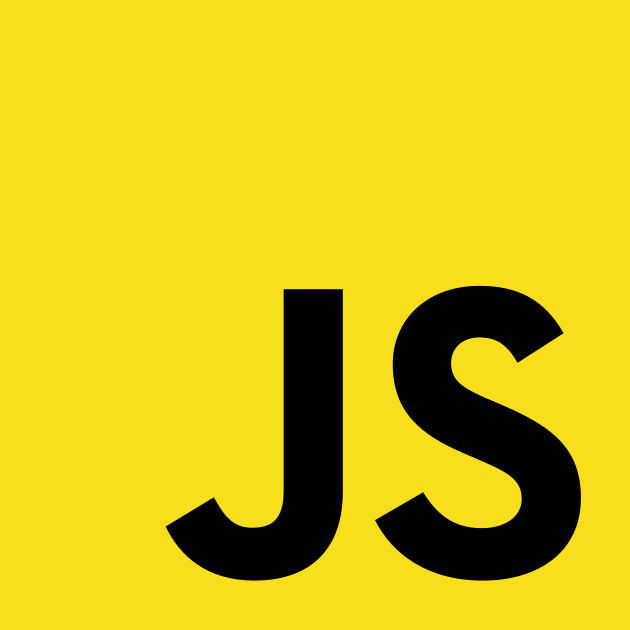

In [2]:
$$svg$$ = `
<svg xmlns="http://www.w3.org/2000/svg" version="1.1" viewBox="0 0 630 630" height="90">
<g id="logo">
  <rect id="background" x="0" y="0" width="630" height="630" fill="#f7df1e" />
  <path id="j" d="m 165.65,526.47375 48.2125,-29.1775 C 223.16375,513.7875 231.625,527.74 251.92,527.74 c 19.45375,0 31.71875,-7.60975 31.71875,-37.21 l 0,-201.3 59.20375,0 0,202.1375 c 0,61.32 -35.94375,89.23125 -88.385,89.23125 -47.36125,0 -74.8525,-24.52875 -88.8075,-54.13" />
  <path id="s" d="m 375,520.13 48.20625,-27.91125 c 12.69,20.72375 29.1825,35.9475 58.36125,35.9475 24.53125,0 40.17375,-12.26475 40.17375,-29.18125 0,-20.29875 -16.06875,-27.48875 -43.135,-39.32625 l -14.7975,-6.3475 c -42.715,-18.18125 -71.05,-41.0175 -71.05,-89.2275 0,-44.40375 33.83125,-78.2375 86.695,-78.2375 37.6375,0 64.7025,13.11125 84.15375,47.36625 l -46.09625,29.60125 c -10.15,-18.1825 -21.1425,-25.37125 -38.0575,-25.37125 -17.33875,0 -28.335,10.995 -28.335,25.37125 0,17.7625 10.99625,24.9525 36.3675,35.94875 l 14.8,6.3425 c 50.325,21.56875 78.66,43.5575 78.66,93.03375 0,53.2875 -41.86625,82.465 -98.11,82.465 -54.97625,0 -90.5,-26.2175 -107.83625,-60.47375" />
</g>
</svg>
`

In [3]:
var Immutable = require('immutable')
var _ = require('lodash')

# Revival on Parse

JSON.parse takes an extra argument called a reviver:

```
JSON.parse(text[, reviver])
```

The reviver accepts two parameters, `key` and `value` and returns the intended `value`. The key will either be a text key on Objects or numbers for when the value is in an Array.

Let's walk through some sample code to check this out.

In [4]:
// Classic JSON.parse
JSON.parse('{"a": 2, "b": { "name": "dave" }}')

{ a: 2, b: { name: 'dave' } }

In [5]:
function reviver(key, value) {
    if(key === 'name') {
        return value + " senior";
    }
    return value
}

JSON.parse('{"a": 2, "b": { "name": "dave" }}', reviver)

{ a: 2, b: { name: 'dave senior' } }

This means you can use this to change values based on a key, though you won't know the nested path of the overall JSON object. 

Since the string is (expected to be) JSON, there are only two types which are not immutable: `Array` and `Object`. You can use this to your advantage to create frozen or Immutable.js objects while parsing.

In [6]:
JSON.parse('{"a": 2, "b": { "name": "dave" }}', (k, v) => Object.freeze(v))

{ a: 2, b: { name: 'dave' } }

In [7]:
function immutableReviver(key, value) {
    if (Array.isArray(value)) {
        return Immutable.List(value);
    }

    if (typeof value === 'object') {
        return Immutable.Map(value)
    }
    return value;
}

Since it seemed handy enough, I put [`immutable-reviver`](https://github.com/rgbkrk/immutable-reviver) on npm. We'll just use the version written here for now though.

In [8]:
revived = JSON.parse('{"a": 2, "b": { "name": "dave" }}', immutableReviver)

Map {
  size: 2,
  _root: ArrayMapNode { ownerID: OwnerID {}, entries: [ [Array], [Array] ] },
  __ownerID: undefined,
  __hash: undefined,
  __altered: false
}

In [9]:
revived.getIn(['b', 'name'])

'dave'

The reason I started looking into this was because I was trying to see if I could optimize loading of notebooks in nteract. We currently rely on a strategy that goes like:

```
notebook = JSON.parse(rawNotebook)
immutableNotebook = Immutable.fromJS(notebook)

ourNotebook = immutableNotebook.map(...).map(...)... // A series of transformations to create our in-memory representation
```

These transformations are mostly to turn notebook cells from this:


```
{
  "metadata": {
    "collapsed": false,
    "outputExpanded": false
  },
  "cell_type": "markdown",
  "source": [
    "# Outputs you can update by name\n",
    "\n",
    "This notebook demonstrates the new name-based display functionality in the notebook. Previously, notebooks could only attach output to the cell that was currently being executed:\n",
    "\n"
  ]
}
```

into:

```
{
  "metadata": {
    "collapsed": false,
    "outputExpanded": false
  },
  "cell_type": "markdown",
  "source": "# Outputs you can update by name\n\nThis notebook demonstrates the new name-based display functionality in the notebook. Previously, notebooks could only attach output to the cell that was currently being executed:\n\n"
}
```

This multi-line string format, introduced by Jupyter, is to accomodate diffing of notebooks in tools like git and GitHub. It's applied to source on cells as well as some output types.

We can set up a reviver that handles all the keys that are most likely to have [multi-line strings](https://github.com/jupyter/nbformat/blob/62d6eb8803616d198eaa2024604d1fe923f2a7b3/nbformat/v4/nbformat.v4.schema.json#L386). We'll start with those that are media types that we know end up being encoded as an array of strings.

In [10]:
var multilineStringMimetypes = new Set([
    'application/javascript',
    'text/html',
    'text/markdown',
    'text/latex',
    'image/svg+xml',
    'image/gif',
    'image/png',
    'image/jpeg',
    'application/pdf',
    'text/plain',
]);

function immutableNBReviver(key, value) {
    if (Array.isArray(value)) {
        if(multilineStringMimetypes.has(key)) {
            return value.join('')
        }
        return Immutable.List(value);
    }

    if (typeof value === 'object') {
        return Immutable.Map(value)
    }
    return value;
}

We can also set up a "greedy" reviver that will also convert `source` and `text` fields. The primary problem with this though, because of how JSON.parse works is that we have no idea if it's a key in a cell where we expect, part of someone else's JSON payload, or in metadata.

In [11]:
var specialKeys = new Set([
    'application/javascript',
    'text/html',
    'text/markdown',
    'text/latex',
    'image/svg+xml',
    'image/gif',
    'image/png',
    'image/jpeg',
    'application/pdf',
    'text/plain',
    'source',
    'text',
]);

function immutableGreedyReviver(key, value) {
    if (Array.isArray(value)) {
        if(specialKeys.has(key)) {
            return value.join('')
        }
        return Immutable.List(value);
    }

    if (typeof value === 'object') {
        return Immutable.Map(value)
    }
    return value;
}

# Our runtime harnesses

To evaluate the speed at which we can revive our objects, we'll set up a little testing harness.

In [12]:
// Some logger that uses process.hrtime that I ripped off Stack Overflow, since we want to use timing in a way that we can't with console.time

[ a, o, ms, s, log ] = ( function * () {
    yield * [
        ( process.hrtime )(),
        process.hrtime,
        ms => ( ( ms[ 0 ] * 1e9 + ms[ 1 ] ) / 1000000 ),
        s  => s / 1000,
        () => {
            const f = o( a ), msf = ms( f ), sf = s( msf );
            return { a, o: f, ms: msf, s: sf };
        }
    ];
} )();

Object [Generator] {}

In [13]:
// Calculate the milliseconds it takes to run f
function measure(f) {
  start = log()
  f()
  end = log()
  return end.ms - start.ms  
}

// measure the function run n times, return the mean
function runTrials(f, n=1000) {
    values = []
    for(var ii=0; ii < n; ii++) {
        values.push(measure(f))
    }
    return values.reduce((a, b) => a + b, 0)/n
}

With our harness all set up, we can run through all the notebooks we have locally to see how they perform with different revivers.

In [14]:
notebooks = require('glob').sync('./*.ipynb')

Error: Cannot find module 'glob'
Require stack:
- C:\ProgramData\chocolatey\lib\nteract.portable\tools\nteract\resources\app.asar.unpacked\node_modules\@nteract\examples\node.js\[eval]

In [15]:
for(var notebookPath of notebooks) {
    console.log("\n ----- ", path.basename(notebookPath))
    raw = fs.readFileSync(notebookPath)
    
    var tests = [
        { name: 'straight JSON.parse', f: () => { JSON.parse(raw) } },
        { name: 'Object.freeze', f: () => { JSON.parse(raw, (k, v) => Object.freeze(v)) } },
        { name: 'basic Immutable', f: () => { JSON.parse(raw, immutableReviver) } },
        { name: 'immutable notebook', f: () => { JSON.parse(raw, immutableNBReviver) } },
        { name: 'immutable greedy nb', f: () => { JSON.parse(raw, immutableGreedyReviver) } },
        // { name: 'fromJS', f: () => { JSON.parse(raw, (k, v) => Immutable.fromJS(v)) } },
        // { name: 'current commutable way', f: () => { commutable.fromJS(JSON.parse(raw)) } },
    ]
    
    for(var test of tests) {
        mean = runTrials(test.f, 100)
        console.log(_.padEnd(test.name, 30), mean)
    }
    

}



# Evaluating revivers for notebook loading.

Within nteract we are inevitably going to end up creating an immutable structure. These measurements only make sense in the context of running both the initial `JSON.parse` followed by the transformations. To give it a rough guess, I'll only compare a few I can evaluate.

In [16]:
for(var notebookPath of notebooks) {
    console.log("\n ----- ", path.basename(notebookPath))
    raw = fs.readFileSync(notebookPath)
    
    var tests = [
        { name: 'straight JSON.parse baseline', f: () => { JSON.parse(raw) } },
        { name: 'Object.freeze baseline', f: () => { JSON.parse(raw, (k,v) => Object.freeze(v)) } },
        { name: 'immutable greedy nb', f: () => { JSON.parse(raw, immutableGreedyReviver) } },
    ]
    
    for(var test of tests) {
        mean = runTrials(test.f, 100)
        console.log(_.padEnd(test.name, 50), mean.toString().slice(0,10), 'ms')
    }
}

Since these are in milliseconds and the difference is not much, it seems like maybe this doesn't need to be optimized. In the case of the altair notebook, which has a pretty big JSON structure inside (and only one!), perhaps it would make sense if some of our structure is frozen objects (don't force vega payloads to be Immutable Maps).

```
 -----  altair.ipynb
straight JSON.parse baseline                       1.10996391 ms
Object.freeze baseline                             2.29745900 ms
straight JSON.parse then commutable conversion     6.84918417 ms
immutable greedy nb                                5.85418076 ms
```